## Benchmarking genetic perturbation prediction in human PSC's

This project aims to assess the ability of modern datasets and software tools to predict the effect of genetic perturbations on the transcriptome. Check out [the proposal](https://docs.google.com/document/d/1vvZi5c0nU3VTvKiWpEka8AtDORxJ3Ymv0ZzoFQwoDoI/edit) for more information.

There are several opportunities for interesting work in this area. This demo focuses on *causal structure inference* and *causal effect estimation* by pairing CellOracle with various different base networks. 

In [81]:
VERSION="v4"
import warnings
with warnings.catch_warnings():
    import regex as re
    import os
    import shutil
    import sys
    import importlib
    import matplotlib.colors as colors
    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd
    import scanpy as sc
    import seaborn as sns
    import celloracle as co
    from scipy.stats import spearmanr as spearmanr
    # visualization settings
    %config InlineBackend.figure_format = 'retina'
    %matplotlib inline
    plt.rcParams['figure.figsize'] = [6, 4.5]
    plt.rcParams["savefig.dpi"] = 300

    try:
        os.makedirs("../results/" + VERSION)
    except:
        pass

### Networks

This sets up access to a collection of pre-built regulatory networks and coexpression networks. 

In [2]:
sys.path.append(os.path.expanduser('/home/ekernf01/Desktop/jhu/research/projects/perturbation_prediction/cell_type_knowledge_transfer/networks/load_networks/')) 
import load_networks
importlib.reload(load_networks) #under development; get latest easily
os.environ["GRN_PATH"] = "../../networks/networks/"

### Basic infrastructure

The software for this project will provide quick access to a variety of modeling choices, especially different base networks, different network structure pruning methods, possibly different learning algorithms, and definitely different handling of velocity and timestamps. We will try to separate this into one-off components specific to each dataset or comparison and reusable components. Here is a rough draft of one reusable component, for training models with various base networks.

In [3]:
def trainCausalModelAndPredict(expression, 
                               baseNetwork, 
                               memoizationName,
                               perturbations,
                               clusterColumnName,
                               pruningParameters = {"p":0.001, "threshold_number":2000}):
    """Train a causal model and predict outcomes of unseen perturbations."""
    print("Working on " + memoizationName)
    oracle = co.Oracle()
    oracle.import_anndata_as_raw_count(adata=ko_lab_esc_data,
                                   cluster_column_name=clusterColumnName,
                                   embedding_name="X_pca")
    oracle.import_TF_data(TF_info_matrix=baseNetwork)
    oracle.perform_PCA()
    n_comps = 50
    k = 1
    oracle.knn_imputation(n_pca_dims=n_comps, k=k, balanced=True, b_sight=k*8,
                          b_maxl=k*4, n_jobs=4)
    # Ridge regression pruning
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=DeprecationWarning)
        links = oracle.get_links(cluster_name_for_GRN_unit=clusterColumnName, 
                                 alpha=10, 
                                 model_method = "bayesian_ridge",
                                 verbose_level=10,    
                                 test_mode=False, 
                                 n_jobs=14)
        links.filter_links(p=pruningParameters["p"], 
                           weight="coef_abs", 
                           threshold_number=pruningParameters["threshold_number"])
    
    links.links_dict = links.filtered_links.copy()
    oracle.get_cluster_specific_TFdict_from_Links(links_object=links)
    oracle.fit_GRN_for_simulation(alpha=10, use_cluster_specific_TFdict=True)
    oracle.to_hdf5(file_path=memoizationName)

    output = {}
    for goi, level in perturbations:
        print("Predicting " + goi)
        try:
            oracle.simulate_shift(perturb_condition={goi: level}, n_propagation=3, ignore_warning = True)
            output[goi] = oracle.adata["Control",:].layers['simulated_count'].squeeze()
        except ValueError as e:
            output[goi] = np.nan
            print("Prediction failed for " + goi + " with error " + str(e))
    return output

### Base network options

The project will also develop a reusable collection of datasets on *perturbation experiments* and *network structures* stored in a standardized format. This is not very far along at time of writing, but here are some of the network structures we will use for this example. 

- A completely dense network with all connections allowed
- A completely empty network with no connections allowed 
    - EDIT: CellOracle refuses to make predictions based on an empty network. I have two substitutes for now. One is a random network. Edges are present with 10% probability, all independent. Another is a network where decoy genes, which are iid unit Gaussian, are the only regulators for each target.
- CellOracle default (motif analysis of promoters)
- Motif analysis of FANTOM5 CAGE-seq data
- Coexpression analysis from the CellNet compendia


In [4]:
humanTFs = pd.read_csv("../../accessory_data/humanTFs.csv")
targetGenes = co.data.load_human_promoter_base_GRN()["gene_short_name"]

def networkEdgesToMatrix(networkEdges, regulatorColumn=0, targetColumn=1):
    """Reformat a network from a two-column dataframe to the way that celloracle needs its input."""
    X = pd.crosstab(networkEdges.iloc[:,targetColumn], networkEdges.iloc[:,regulatorColumn])
    X = 1.0*(X > 0)
    X = X.rename_axis('gene_short_name').reset_index()
    X = X.rename_axis('peak_id').reset_index()
    return X

def makeRandomNetwork(density = 0, seed = 0):
    """Format an random network the way that celloracle needs its input."""
    np.random.seed(seed)
    return pd.DataFrame(
            np.random.binomial(
                n = 1, 
                p=density,
                size=(
                    len(targetGenes), 
                    len(humanTFs['HGNC symbol'])
                )
            ),
            columns = humanTFs['HGNC symbol'], 
            index = targetGenes
        ).rename_axis('gene_short_name').reset_index().rename_axis('peak_id').reset_index()

networks = {
    'dense': makeRandomNetwork(density = 1),
    'random0.1': makeRandomNetwork(density = 0.1),
    'cellOracle': co.data.load_human_promoter_base_GRN(),
    'fantom5': networkEdgesToMatrix(load_networks.load_grn_all_subnetworks("magnum_compendium_394")),
    'cellnet': networkEdgesToMatrix(load_networks.load_grn_all_subnetworks("cellnet_human_Hg1332"))
}

Loading prebuilt promoter base-GRN. Version: hg19_gimmemotifsv5_fpr2
Loading prebuilt promoter base-GRN. Version: hg19_gimmemotifsv5_fpr2


In [5]:
# Inspect for correctness.
# They should all be zeroes and ones.
print({bn:np.unique(networks[bn].iloc[:,2:]) for bn in networks})

{'dense': array([1]), 'random0.1': array([0, 1]), 'cellOracle': array([0., 1.]), 'fantom5': array([0., 1.]), 'cellnet': array([0., 1.])}


In [63]:
# Inspect sizes. 
network_sizes = pd.DataFrame({bn:networks[bn].iloc[:,2:].sum().sum() for bn in networks}, index = ["numEdges"])
network_sizes = network_sizes.T.reset_index().rename({"index":"network"}, axis = 1)
network_sizes

,network,numEdges
0,dense,102313295.0
1,random0.1,10227517.0
2,cellOracle,5134330.0
3,fantom5,3246008.0
4,cellnet,201422.0


### PSC overexpression example

This demo uses a dataset with hundreds of individual overexpression experiments applied to pluripotent stem cells ([Nakatake et al 2020](https://www.sciencedirect.com/science/article/pii/S2211124720306082)). This choice of dataset is meant to be an easy starting point: the time-scale (48 hours) is fairly short-term, the cell state (pluripotency) is well studied,  and the perturbations are numerous (714 genes including 481 TF's). The dataset is also small (~1k samples) so testing/debugging is fast. 

Here we tidy the PSC overexpression dataset and carry out a simple exploration in scanpy. (It's not single cell data but scanpy is clearly a useful place to start.) The data contain both microarray and RNA-seq measurements, but these have already been effectively integrated by the authors using a strategy akin to quantile normalization. There are missing values marked -9999, which include genes missing from microarrays and outlying measurements censored by the creators. For now, missing values are being filled in with control gene expression. 

There are three types of negative control *samples*, labeled "control", "emerald", and "CAG-rtTA35-IH". 

In [18]:
controls = ("Emerald", "Control", "CAG-rtTA35-IH")
ko_lab_esc_data = pd.read_csv("../../raw_perturbations/ko_esc/CREST_06162021.txt", 
                              delimiter="\t",
                              index_col=0, 
                              header=0, 
                              comment = '!')    
gene_metadata   = ko_lab_esc_data.iloc[:,-4:]
ko_lab_esc_data = ko_lab_esc_data.iloc[:, 0:-4].T
sample_metadata = pd.DataFrame(columns = ["perturbation"], 
                               index = ko_lab_esc_data.index,
                               data = [re.sub("\..", "", g) for g in ko_lab_esc_data.index])
for c in controls:
    assert c in sample_metadata['perturbation'].unique() 

In [19]:
def missingDataPerGene(ko_lab_esc_data):
    gene_metadata["fraction_missing"] = pd.DataFrame.mean(ko_lab_esc_data==-9999)
    missingness_rates = gene_metadata["fraction_missing"].value_counts()
    missingness_rates = pd.DataFrame(index = range(len(missingness_rates.index)), 
                                 data = {"Fraction of samples missing":np.array(missingness_rates.index), 
                                         "Number of genes": np.array(missingness_rates)})
    print("Missing data per gene:")
    print(missingness_rates)
    
missingDataPerGene(ko_lab_esc_data)
for sample in ko_lab_esc_data.index:
    missing = ko_lab_esc_data.loc[sample,:]==-9999
    ko_lab_esc_data.loc[sample,missing] = ko_lab_esc_data.loc["Control",missing]
missingDataPerGene(ko_lab_esc_data)

ko_lab_esc_data = sc.AnnData(ko_lab_esc_data, 
                             var = gene_metadata,
                             obs = sample_metadata)
ko_lab_esc_data

Missing data per gene:
   Fraction of samples missing  Number of genes
0                     0.000000            20032
1                     0.151186             4804
2                     0.000988              214
3                     0.152174               33
4                     0.001976                7
Missing data per gene:
   Fraction of samples missing  Number of genes
0                          0.0            25090


AnnData object with n_obs × n_vars = 1012 × 25090
    obs: 'perturbation'
    var: 'Symbol', 'Gene title', 'GENBANK', 'Entrez', 'fraction_missing'

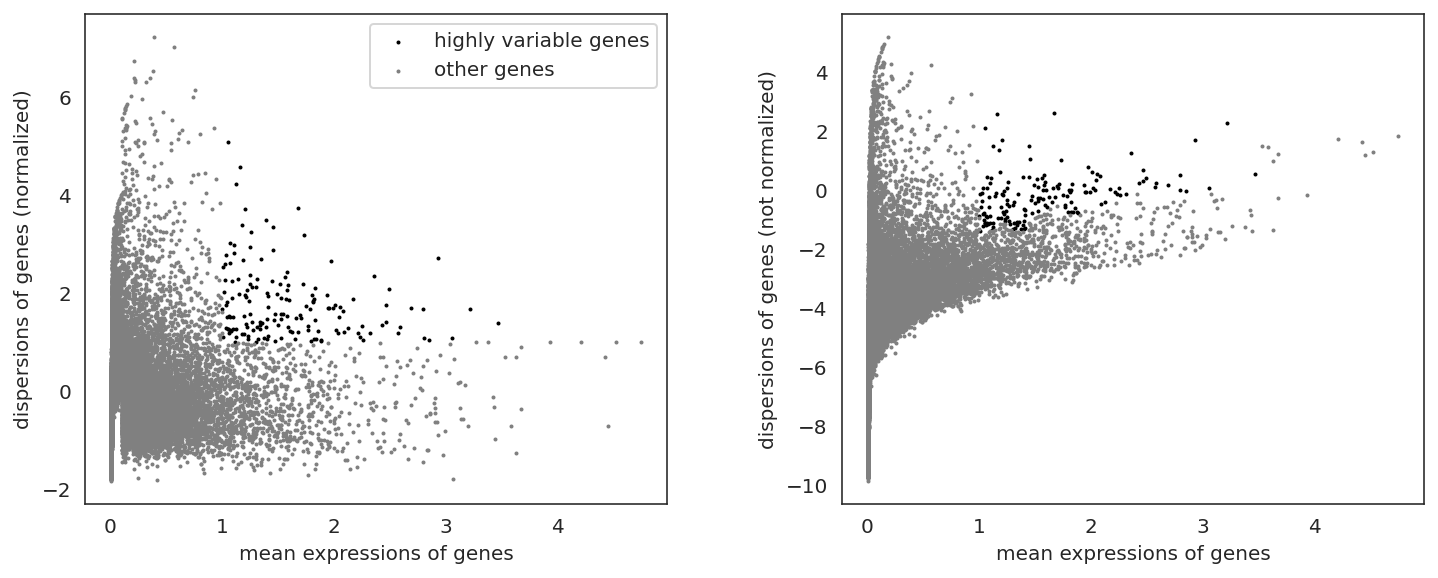

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'perturbation' as categorical
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'Symbol' as categorical
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning

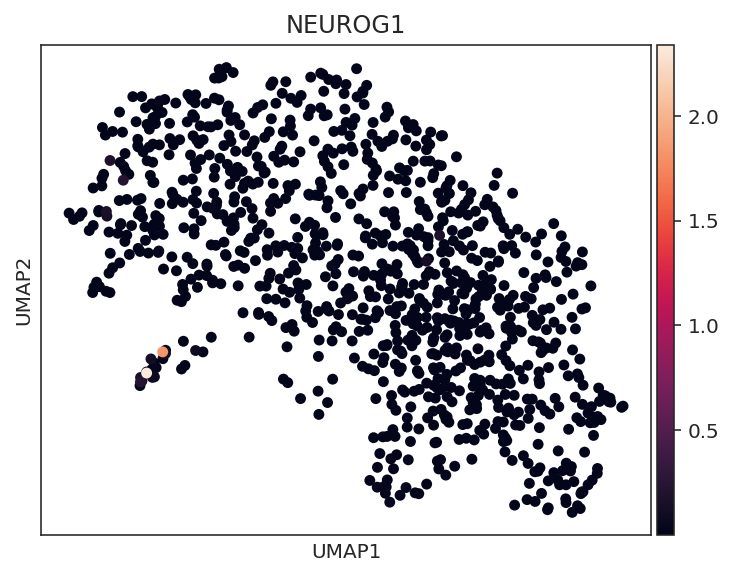

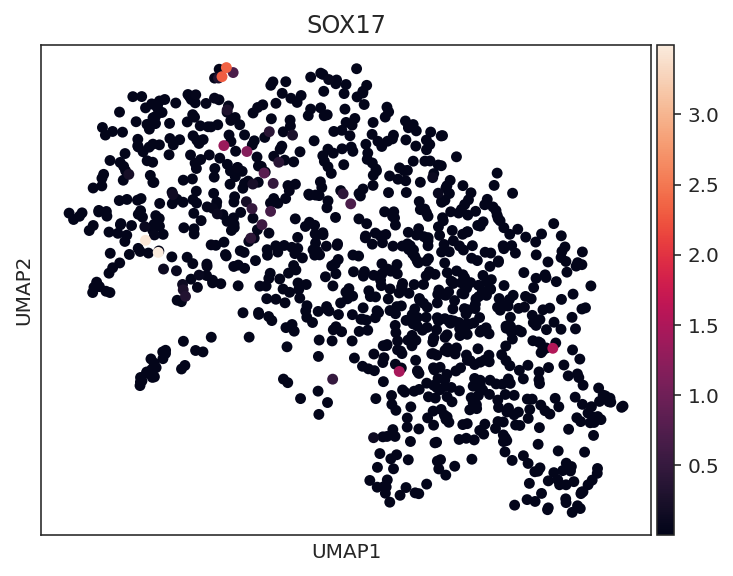

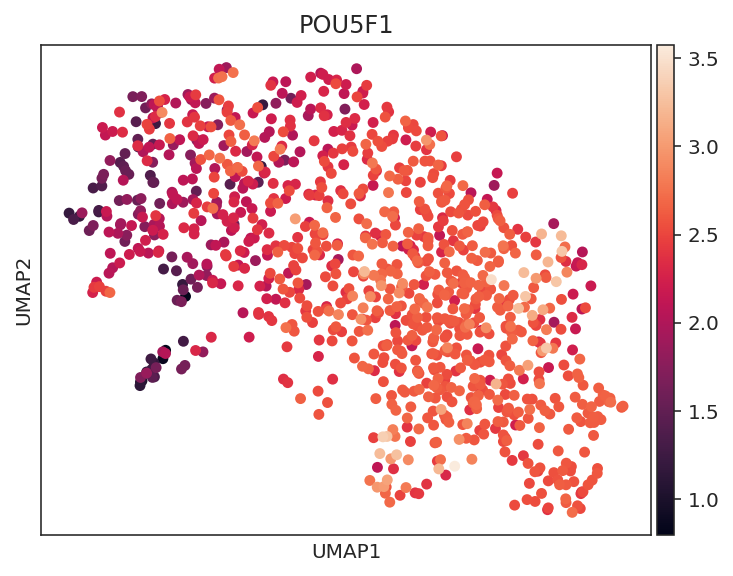

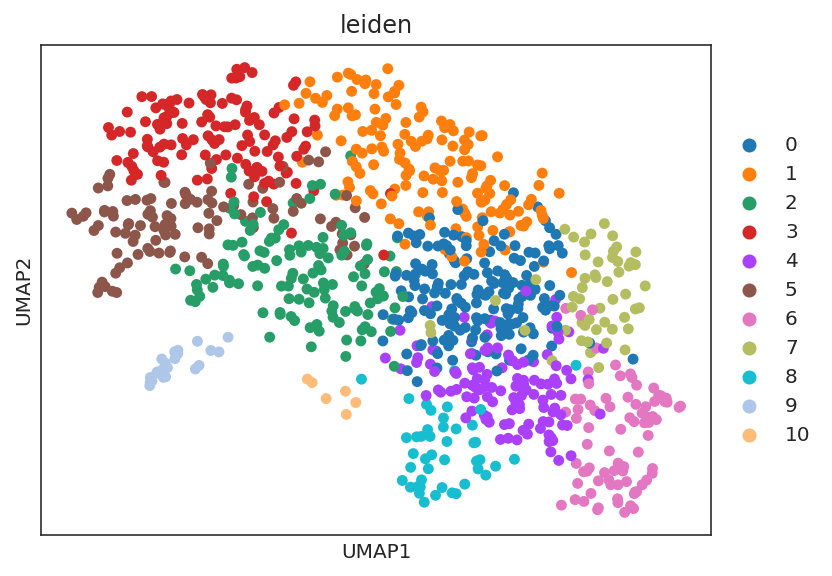

In [20]:
sc.pp.normalize_total(ko_lab_esc_data, target_sum=1e4)
sc.pp.log1p(ko_lab_esc_data)
sc.pp.highly_variable_genes(ko_lab_esc_data, min_mean=1, max_mean=4, min_disp=1, n_bins=50)
sc.pl.highly_variable_genes(ko_lab_esc_data)
with warnings.catch_warnings():
    sc.tl.pca(ko_lab_esc_data, n_comps=100)
sc.pp.neighbors(ko_lab_esc_data)
sc.tl.umap(ko_lab_esc_data)
sc.tl.leiden(ko_lab_esc_data)
sc.pl.umap(ko_lab_esc_data, color = "NEUROG1")
sc.pl.umap(ko_lab_esc_data, color = "SOX17")
sc.pl.umap(ko_lab_esc_data, color = "POU5F1")
sc.pl.umap(ko_lab_esc_data, color = "leiden")
# Due to the small number of samples, ask CO to use only one cluster.
# Requires setting certain other undocumented aspects of object state. :(
ko_lab_esc_data.obs["fake_cluster"]="all_one_cluster"
ko_lab_esc_data.obs.fake_cluster = ko_lab_esc_data.obs.fake_cluster.astype("category")
ko_lab_esc_data.uns["fake_cluster_colors"] = ['#1f77b4']

### Data reduction

With only 64GB of RAM, I have been unable to make whole-transcriptome predictions with CellOracle. A data reduction step is necessary where only highly variable genes are included. We also keep all genes that are perturbed, whether or not they appear highly variable -- unless they are unavailable in the first place. 

In [21]:
perturbed_genes = set(list(ko_lab_esc_data.obs['perturbation'].unique())).difference(controls)
perturbed_and_measured_genes = perturbed_genes.intersection(ko_lab_esc_data.var.index)
perturbed_but_not_measured_genes = perturbed_genes.difference(ko_lab_esc_data.var.index)
print("These genes were perturbed but not measured:")
print(perturbed_but_not_measured_genes)
genes_keep = ko_lab_esc_data.var.index[ko_lab_esc_data.var['highly_variable']]
genes_keep = set(genes_keep).union(perturbed_and_measured_genes)
ko_lab_esc_data = ko_lab_esc_data[:,list(genes_keep)]

These genes were perturbed but not measured:
{'DUX4', 'T'}


### Training and test split

A few factors complicate the training-test split. 

- Perturbed genes may be absent from most base GRN's due to lack of motif information or ChIP data. These are excluded from the test data to avoid obvious failure cases.
- Perturbed genes may not be measured. These are excluded from test data because we don't know to what extent they were overexpressed.

In both cases, we still use those perturbed profiles as training data, hoping they will provide useful info about attainable cell states and downstream causal effects. There are so many factors ineligible for use as test data that we use all the eligible ones for test and the only ineligible ones for training. 

In [22]:
test_set_regulators = set.intersection(*[set(networks[key]['gene_short_name']) 
                                      for key in networks if not key == 'empty'])
test_set_regulators = test_set_regulators.difference(perturbed_but_not_measured_genes)
testSetPerturbations     = set(ko_lab_esc_data.obs['perturbation']).intersection(test_set_regulators)
trainingSetPerturbations = set(ko_lab_esc_data.obs['perturbation']).difference(test_set_regulators)
ko_lab_esc_data_heldout  = ko_lab_esc_data[ko_lab_esc_data.obs["perturbation"].isin(testSetPerturbations),    :]
ko_lab_esc_data_train    = ko_lab_esc_data[ko_lab_esc_data.obs["perturbation"].isin(trainingSetPerturbations),:]
ko_lab_esc_data_train.obs['perturbation'].unique()
perturbationsToPredict = [(gene, ko_lab_esc_data_heldout[sample, gene].X[0,0]) for sample,gene in enumerate(ko_lab_esc_data_heldout.obs['perturbation'])] 
print("Example perturbations formatted as \n (gene, expression after perturbation)")
print(perturbationsToPredict[0:5])
print("Test set size:")
print(len(testSetPerturbations))
print("Training set size:")
print(len(trainingSetPerturbations))
# ko_lab_esc_data_train


Example perturbations formatted as 
 (gene, expression after perturbation)
[('ANKRD22', 0.43029666), ('ANKRD22', 0.46850818), ('ARID3A', 2.8244312), ('ARID3A', 2.6300352), ('ARNT2', 3.8641534)]
Test set size:
288
Training set size:
225


### OK, let's do this. 

In [23]:
n_networks = len(networks.keys())
experiments = pd.DataFrame({"network":[n for n in networks.keys()]*2, 
                            "p":[0.001, 1]*n_networks,
                            "threshold_number":[2000, max(network_sizes.values())]*n_networks,
                            "pruning":["harsh", "none"]*n_networks})
experiments["index"] = experiments.index
experiments.to_csv("../results/" + VERSION + "/networkExperiments.csv")

In [24]:
predictions = {
    i: trainCausalModelAndPredict(expression=ko_lab_esc_data_train,
                                  baseNetwork=networks[experiments.loc[i,'network']],
                                  memoizationName="../results/" + VERSION + "/" + str(i) + ".celloracle.oracle", 
                                  perturbations=perturbationsToPredict,
                                  clusterColumnName = "fake_cluster",
                                  pruningParameters = {"p":experiments.loc[i,'p'], 
                                                       "threshold_number":experiments.loc[i,'threshold_number']}) 
    for i in experiments.index
}


Working on ../results/v3/0.celloracle.oracle
653 genes were found in the adata. Note that Celloracle is intended to use 1000 to 3000 genes, so the behavior with this number of genes may differ from what is expected.


  0%|          | 0/1 [00:00<?, ?it/s]

inferring GRN for all_one_cluster...


  0%|          | 0/629 [00:00<?, ?it/s]

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encounter

fitting GRN again...
calculating GRN in all_one_cluster


  0%|          | 0/653 [00:00<?, ?it/s]

genes_in_gem: 653
models made for 268 genes
Predicting ANKRD22
Prediction failed for ANKRD22 with error Gene ANKRD22 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting ANKRD22
Prediction failed for ANKRD22 with error Gene ANKRD22 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting ARID3A
Prediction failed for ARID3A with error Gene ARID3A does not have enough regulatory connection in the GRNs. Cannot perform simulation.
Predicting ARID3A
Prediction failed for ARID3A with error Gene ARID3A does not have enough regulatory connection in the GRNs. Cannot perform simulation.
Predicting ARNT2
Predicting ARNT2
Predicting ASCL1
Predicting ASCL1
Predicting ASCL2
Predicting ASCL2
Predicting ATF1
Prediction failed for ATF1 with error Gene ATF1 does not have enough regulatory connection in the GRNs. Cannot perform simulation.
Predicting ATF1
Predictio

Predicting FLI1
Predicting FOS
Prediction failed for FOS with error Gene FOS does not have enough regulatory connection in the GRNs. Cannot perform simulation.
Predicting FOS
Prediction failed for FOS with error Gene FOS does not have enough regulatory connection in the GRNs. Cannot perform simulation.
Predicting FOSL1
Predicting FOSL1
Predicting FOXA1
Predicting FOXA1
Predicting FOXA2
Predicting FOXA2
Predicting FOXD1
Predicting FOXD1
Predicting FOXF1
Predicting FOXF1
Predicting FOXG1
Predicting FOXG1
Predicting FOXH1
Predicting FOXH1
Predicting FOXL2
Prediction failed for FOXL2 with error Gene FOXL2 does not have enough regulatory connection in the GRNs. Cannot perform simulation.
Predicting FOXL2
Prediction failed for FOXL2 with error Gene FOXL2 does not have enough regulatory connection in the GRNs. Cannot perform simulation.
Predicting FOXM1
Predicting FOXM1
Predicting FOXN3
Predicting FOXN3
Predicting FOXP1
Predicting FOXP1
Predicting FOXP1
Predicting FOXS1
Prediction failed for 

Predicting MEF2C
Predicting MEIS1
Prediction failed for MEIS1 with error Gene MEIS1 does not have enough regulatory connection in the GRNs. Cannot perform simulation.
Predicting MEIS1
Prediction failed for MEIS1 with error Gene MEIS1 does not have enough regulatory connection in the GRNs. Cannot perform simulation.
Predicting MEIS2
Prediction failed for MEIS2 with error Gene MEIS2 does not have enough regulatory connection in the GRNs. Cannot perform simulation.
Predicting MEIS2
Prediction failed for MEIS2 with error Gene MEIS2 does not have enough regulatory connection in the GRNs. Cannot perform simulation.
Predicting MKRN1
Prediction failed for MKRN1 with error Gene MKRN1 does not have enough regulatory connection in the GRNs. Cannot perform simulation.
Predicting MKRN1
Prediction failed for MKRN1 with error Gene MKRN1 does not have enough regulatory connection in the GRNs. Cannot perform simulation.
Predicting MNX1
Predicting MNX1
Predicting MSC
Prediction failed for MSC with error

Predicting SALL1
Predicting SALL4
Predicting SALL4
Predicting SAP30
Prediction failed for SAP30 with error Gene SAP30 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting SETDB1
Prediction failed for SETDB1 with error Gene SETDB1 does not have enough regulatory connection in the GRNs. Cannot perform simulation.
Predicting SETDB1
Prediction failed for SETDB1 with error Gene SETDB1 does not have enough regulatory connection in the GRNs. Cannot perform simulation.
Predicting SIM1
Prediction failed for SIM1 with error Gene SIM1 does not have enough regulatory connection in the GRNs. Cannot perform simulation.
Predicting SIM1
Prediction failed for SIM1 with error Gene SIM1 does not have enough regulatory connection in the GRNs. Cannot perform simulation.
Predicting SIRT3
Prediction failed for SIRT3 with error Gene SIRT3 does not have enough regulatory connection in the GRNs. Cannot perform simulation.
Predicting SIRT3


Predicting ZNF281
Predicting ARID3B
Predicting ARID3B
Predicting BMP2
Predicting BMP2
Predicting BMP7
Predicting BMP7
Predicting CBFB
Predicting CBX3
Prediction failed for CBX3 with error Gene CBX3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting CBX3
Prediction failed for CBX3 with error Gene CBX3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting CHD5
Prediction failed for CHD5 with error Gene CHD5 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting CHD5
Prediction failed for CHD5 with error Gene CHD5 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting CITED1
Predicting CITED1
Predicting CXXC5
Predicting CXXC5
Predicting DMRT2
Predicting DMRT2
Predicting E2F3
Predicting E2F3
Predicting E2F

  0%|          | 0/1 [00:00<?, ?it/s]

inferring GRN for all_one_cluster...


  0%|          | 0/629 [00:00<?, ?it/s]

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)


fitting GRN again...
calculating GRN in all_one_cluster


  0%|          | 0/653 [00:00<?, ?it/s]

genes_in_gem: 653
models made for 629 genes
Predicting ANKRD22
Prediction failed for ANKRD22 with error Gene ANKRD22 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting ANKRD22
Prediction failed for ANKRD22 with error Gene ANKRD22 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting ARID3A
Predicting ARID3A
Predicting ARNT2
Predicting ARNT2
Predicting ASCL1
Predicting ASCL1
Predicting ASCL2
Predicting ASCL2
Predicting ATF1
Predicting ATF1
Predicting ATF3
Predicting ATF3
Predicting ATOH1
Predicting ATOH1
Predicting BATF
Predicting BATF
Predicting BATF3
Predicting BATF3
Predicting BCL6
Predicting BCL6
Predicting BMP4
Predicting BMP4
Predicting BRF2
Predicting BRF2
Predicting CBX2
Predicting CBX2
Predicting CCNE1
Prediction failed for CCNE1 with error Gene CCNE1 is not included in the base GRN; It is not TF or TF motif information is not availa

Predicting MEF2C
Predicting MEIS1
Predicting MEIS1
Predicting MEIS2
Predicting MEIS2
Predicting MKRN1
Predicting MKRN1
Predicting MNX1
Predicting MNX1
Predicting MSC
Predicting MSC
Predicting MSX2
Predicting MSX2
Predicting MXI1
Predicting MXI1
Predicting MYB
Predicting MYB
Predicting MYBL2
Predicting MYBL2
Predicting MYC
Predicting MYC
Predicting MYF5
Predicting MYF5
Predicting MYF6
Predicting MYF6
Predicting MYOD1
Predicting MYOD1
Predicting NANOG
Predicting NANOG
Predicting NEUROD1
Predicting NEUROD1
Predicting NEUROD2
Predicting NEUROD2
Predicting NEUROD6
Predicting NEUROD6
Predicting NEUROG1
Predicting NEUROG1
Predicting NFATC1
Predicting NFATC1
Predicting NFE2L1
Predicting NFIB
Predicting NFIB
Predicting NFIC
Predicting NFIC
Predicting NFIL3
Predicting NFIL3
Predicting NKX2-1
Predicting NKX2-1
Predicting NKX2-2
Predicting NKX2-2
Predicting NKX2-5
Predicting NKX2-5
Predicting NKX6-2
Predicting NKX6-2
Predicting NPAS2
Predicting NPAS2
Predicting NR1D2
Predicting NR1D2
Predicting NR

Predicting ZNF274
Predicting ZNF281
Predicting ZNF281
Predicting ARID3B
Predicting ARID3B
Predicting BMP2
Predicting BMP2
Predicting BMP7
Predicting BMP7
Predicting CBFB
Predicting CBX3
Prediction failed for CBX3 with error Gene CBX3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting CBX3
Prediction failed for CBX3 with error Gene CBX3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting CHD5
Prediction failed for CHD5 with error Gene CHD5 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting CHD5
Prediction failed for CHD5 with error Gene CHD5 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting CITED1
Predicting CITED1
Predicting CXXC5
Predicting CXXC5
Predicting DMRT2
Predicting DMRT2
Predicting

  0%|          | 0/1 [00:00<?, ?it/s]

inferring GRN for all_one_cluster...


  0%|          | 0/629 [00:00<?, ?it/s]

fitting GRN again...
calculating GRN in all_one_cluster


  0%|          | 0/653 [00:00<?, ?it/s]

genes_in_gem: 653
models made for 321 genes
Predicting ANKRD22
Prediction failed for ANKRD22 with error Gene ANKRD22 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting ANKRD22
Prediction failed for ANKRD22 with error Gene ANKRD22 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting ARID3A
Predicting ARID3A
Predicting ARNT2
Prediction failed for ARNT2 with error Gene ARNT2 does not have enough regulatory connection in the GRNs. Cannot perform simulation.
Predicting ARNT2
Prediction failed for ARNT2 with error Gene ARNT2 does not have enough regulatory connection in the GRNs. Cannot perform simulation.
Predicting ASCL1
Predicting ASCL1
Predicting ASCL2
Prediction failed for ASCL2 with error Gene ASCL2 does not have enough regulatory connection in the GRNs. Cannot perform simulation.
Predicting ASCL2
Prediction failed for ASCL2 with error Gene

Predicting ELF2
Predicting ELF2
Predicting ELF4
Predicting ELF5
Predicting ELF5
Predicting ELK3
Predicting ELK3
Predicting ELL2
Prediction failed for ELL2 with error Gene ELL2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting ELL2
Prediction failed for ELL2 with error Gene ELL2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting EN1
Prediction failed for EN1 with error Gene EN1 does not have enough regulatory connection in the GRNs. Cannot perform simulation.
Predicting EN1
Prediction failed for EN1 with error Gene EN1 does not have enough regulatory connection in the GRNs. Cannot perform simulation.
Predicting EOMES
Predicting EOMES
Predicting ERG
Prediction failed for ERG with error Gene ERG does not have enough regulatory connection in the GRNs. Cannot perform simulation.
Predicting ERG
Prediction failed for ERG with error Gene ERG doe

Predicting ID1
Predicting ID3
Predicting IKZF1
Predicting IKZF1
Predicting IRF1
Predicting IRF1
Predicting IRF4
Predicting IRF4
Predicting IRF5
Prediction failed for IRF5 with error Gene IRF5 does not have enough regulatory connection in the GRNs. Cannot perform simulation.
Predicting IRF5
Prediction failed for IRF5 with error Gene IRF5 does not have enough regulatory connection in the GRNs. Cannot perform simulation.
Predicting IRX2
Predicting IRX2
Predicting ISL1
Prediction failed for ISL1 with error Gene ISL1 does not have enough regulatory connection in the GRNs. Cannot perform simulation.
Predicting ISL1
Prediction failed for ISL1 with error Gene ISL1 does not have enough regulatory connection in the GRNs. Cannot perform simulation.
Predicting JAG1
Prediction failed for JAG1 with error Gene JAG1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting JAG1
Prediction failed for JAG1 with error Gene JAG1 is not in

Predicting NR2E1
Predicting NR2F2
Predicting NR2F2
Predicting NR3C1
Predicting NR3C1
Predicting NR4A2
Prediction failed for NR4A2 with error Gene NR4A2 does not have enough regulatory connection in the GRNs. Cannot perform simulation.
Predicting NR4A2
Prediction failed for NR4A2 with error Gene NR4A2 does not have enough regulatory connection in the GRNs. Cannot perform simulation.
Predicting NR4A3
Predicting NR4A3
Predicting OLIG1
Predicting OLIG1
Predicting OLIG2
Prediction failed for OLIG2 with error Gene OLIG2 does not have enough regulatory connection in the GRNs. Cannot perform simulation.
Predicting OLIG2
Prediction failed for OLIG2 with error Gene OLIG2 does not have enough regulatory connection in the GRNs. Cannot perform simulation.
Predicting OSTF1
Prediction failed for OSTF1 with error Gene OSTF1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting OSTF1
Prediction failed for OSTF1 with error Gene OSTF

Predicting SNAI1
Predicting SNAI2
Predicting SNAI2
Predicting SNAI3
Predicting SNAI3
Predicting SNAPC1
Prediction failed for SNAPC1 with error Gene SNAPC1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting SNAPC1
Prediction failed for SNAPC1 with error Gene SNAPC1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting SOX10
Predicting SOX10
Predicting SOX17
Predicting SOX17
Predicting SOX2
Predicting SOX2
Predicting SOX5
Prediction failed for SOX5 with error Gene SOX5 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting SOX5
Prediction failed for SOX5 with error Gene SOX5 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting SOX6
Prediction failed for SOX6 with error Gene SOX6 does not have enough re

Predicting ZNF274
Predicting ZNF281
Predicting ZNF281
Predicting ARID3B
Predicting ARID3B
Predicting BMP2
Prediction failed for BMP2 with error Gene BMP2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting BMP2
Prediction failed for BMP2 with error Gene BMP2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting BMP7
Prediction failed for BMP7 with error Gene BMP7 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting BMP7
Prediction failed for BMP7 with error Gene BMP7 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting CBFB
Prediction failed for CBFB with error Gene CBFB does not have enough regulatory connection in the GRNs. Cannot perform simulation.
Predicting CBX3
Prediction failed for CBX3 with

  0%|          | 0/1 [00:00<?, ?it/s]

inferring GRN for all_one_cluster...


  0%|          | 0/602 [00:00<?, ?it/s]

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)


fitting GRN again...
calculating GRN in all_one_cluster


  0%|          | 0/653 [00:00<?, ?it/s]

genes_in_gem: 653
models made for 602 genes
Predicting ANKRD22
Prediction failed for ANKRD22 with error Gene ANKRD22 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting ANKRD22
Prediction failed for ANKRD22 with error Gene ANKRD22 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting ARID3A
Predicting ARID3A
Predicting ARNT2
Prediction failed for ARNT2 with error Gene ARNT2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting ARNT2
Prediction failed for ARNT2 with error Gene ARNT2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting ASCL1
Prediction failed for ASCL1 with error Gene ASCL1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation

Predicting FOXA1
Predicting FOXA2
Predicting FOXA2
Predicting FOXD1
Predicting FOXD1
Predicting FOXF1
Predicting FOXF1
Predicting FOXG1
Predicting FOXG1
Predicting FOXH1
Prediction failed for FOXH1 with error Gene FOXH1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting FOXH1
Prediction failed for FOXH1 with error Gene FOXH1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting FOXL2
Prediction failed for FOXL2 with error Gene FOXL2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting FOXL2
Prediction failed for FOXL2 with error Gene FOXL2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting FOXM1
Predicting FOXM1
Predicting FOXN3
Prediction failed for FOXN3 with error Gene FOXN3 is not included in

Predicting KLF15
Prediction failed for KLF15 with error Gene KLF15 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting KLF15
Prediction failed for KLF15 with error Gene KLF15 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting KLF2
Prediction failed for KLF2 with error Gene KLF2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting KLF2
Prediction failed for KLF2 with error Gene KLF2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting KLF4
Predicting KLF4
Predicting KLF5
Prediction failed for KLF5 with error Gene KLF5 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting KLF5
Prediction failed for KLF5 with error Gene KLF5 is 

Predicting OTX2
Predicting OVOL2
Prediction failed for OVOL2 with error Gene OVOL2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting OVOL2
Prediction failed for OVOL2 with error Gene OVOL2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting PA2G4
Prediction failed for PA2G4 with error Gene PA2G4 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting PA2G4
Prediction failed for PA2G4 with error Gene PA2G4 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting PATZ1
Predicting PATZ1
Predicting PAX2
Predicting PAX2
Predicting PAX5
Predicting PAX5
Predicting PAX6
Predicting PAX6
Predicting PAX8
Predicting PAX8
Predicting PBX1
Predicting PBX1
Predicting PITX2
Predicting PITX2
Predicting PLXNB3
Prediction

Predicting SNAI2
Predicting SNAI3
Prediction failed for SNAI3 with error Gene SNAI3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting SNAI3
Prediction failed for SNAI3 with error Gene SNAI3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting SNAPC1
Prediction failed for SNAPC1 with error Gene SNAPC1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting SNAPC1
Prediction failed for SNAPC1 with error Gene SNAPC1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting SOX10
Predicting SOX10
Predicting SOX17
Predicting SOX17
Predicting SOX2
Predicting SOX2
Predicting SOX5
Predicting SOX5
Predicting SOX6
Prediction failed for SOX6 with error Gene SOX6 is not included in the base GRN; It is not TF or TF m

Predicting DMRT2
Predicting E2F3
Predicting E2F3
Predicting E2F5
Prediction failed for E2F5 with error Gene E2F5 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting E2F5
Prediction failed for E2F5 with error Gene E2F5 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting EMX2
Predicting EMX2
Predicting ETV4
Predicting ETV4
Predicting FGR
Prediction failed for FGR with error Gene FGR is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting FGR
Prediction failed for FGR with error Gene FGR is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting FOSB
Prediction failed for FOSB with error Gene FOSB is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation

  0%|          | 0/1 [00:00<?, ?it/s]

inferring GRN for all_one_cluster...


  0%|          | 0/388 [00:00<?, ?it/s]

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)


fitting GRN again...
calculating GRN in all_one_cluster


  0%|          | 0/653 [00:00<?, ?it/s]

genes_in_gem: 653
models made for 245 genes
Predicting ANKRD22
Prediction failed for ANKRD22 with error Gene ANKRD22 does not have enough regulatory connection in the GRNs. Cannot perform simulation.
Predicting ANKRD22
Prediction failed for ANKRD22 with error Gene ANKRD22 does not have enough regulatory connection in the GRNs. Cannot perform simulation.
Predicting ARID3A
Predicting ARID3A
Predicting ARNT2
Predicting ARNT2
Predicting ASCL1
Prediction failed for ASCL1 with error Gene ASCL1 does not have enough regulatory connection in the GRNs. Cannot perform simulation.
Predicting ASCL1
Prediction failed for ASCL1 with error Gene ASCL1 does not have enough regulatory connection in the GRNs. Cannot perform simulation.
Predicting ASCL2
Prediction failed for ASCL2 with error Gene ASCL2 does not have enough regulatory connection in the GRNs. Cannot perform simulation.
Predicting ASCL2
Prediction failed for ASCL2 with error Gene ASCL2 does not have enough regulatory connection in the GRNs. C

Predicting GATA1
Predicting GATA2
Predicting GATA2
Predicting GATA3
Predicting GATA3
Predicting GATA6
Predicting GATA6
Predicting GRHL2
Predicting GRHL2
Predicting GTF3C2
Predicting GTF3C2
Predicting H2AFZ
Predicting H2AFZ
Predicting HDAC2
Predicting HDAC2
Predicting HDAC6
Prediction failed for HDAC6 with error Gene HDAC6 does not have enough regulatory connection in the GRNs. Cannot perform simulation.
Predicting HDAC6
Prediction failed for HDAC6 with error Gene HDAC6 does not have enough regulatory connection in the GRNs. Cannot perform simulation.
Predicting HES1
Predicting HES1
Predicting HESX1
Predicting HESX1
Predicting HEY1
Prediction failed for HEY1 with error Gene HEY1 does not have enough regulatory connection in the GRNs. Cannot perform simulation.
Predicting HEY1
Prediction failed for HEY1 with error Gene HEY1 does not have enough regulatory connection in the GRNs. Cannot perform simulation.
Predicting HMGA2
Predicting HMGA2
Predicting HMGB2
Predicting HMGB2
Predicting HMGN

Predicting MYB
Predicting MYBL2
Predicting MYBL2
Predicting MYC
Predicting MYC
Predicting MYF5
Predicting MYF5
Predicting MYF6
Prediction failed for MYF6 with error Gene MYF6 does not have enough regulatory connection in the GRNs. Cannot perform simulation.
Predicting MYF6
Prediction failed for MYF6 with error Gene MYF6 does not have enough regulatory connection in the GRNs. Cannot perform simulation.
Predicting MYOD1
Predicting MYOD1
Predicting NANOG
Predicting NANOG
Predicting NEUROD1
Predicting NEUROD1
Predicting NEUROD2
Predicting NEUROD2
Predicting NEUROD6
Prediction failed for NEUROD6 with error Gene NEUROD6 does not have enough regulatory connection in the GRNs. Cannot perform simulation.
Predicting NEUROD6
Prediction failed for NEUROD6 with error Gene NEUROD6 does not have enough regulatory connection in the GRNs. Cannot perform simulation.
Predicting NEUROG1
Prediction failed for NEUROG1 with error Gene NEUROG1 does not have enough regulatory connection in the GRNs. Cannot per

Predicting RUNX1
Predicting RUNX3
Prediction failed for RUNX3 with error Gene RUNX3 does not have enough regulatory connection in the GRNs. Cannot perform simulation.
Predicting RUNX3
Prediction failed for RUNX3 with error Gene RUNX3 does not have enough regulatory connection in the GRNs. Cannot perform simulation.
Predicting RUVBL2
Predicting RUVBL2
Predicting RXRA
Predicting RXRA
Predicting SALL1
Predicting SALL1
Predicting SALL4
Predicting SALL4
Predicting SAP30
Predicting SETDB1
Prediction failed for SETDB1 with error Gene SETDB1 does not have enough regulatory connection in the GRNs. Cannot perform simulation.
Predicting SETDB1
Prediction failed for SETDB1 with error Gene SETDB1 does not have enough regulatory connection in the GRNs. Cannot perform simulation.
Predicting SIM1
Prediction failed for SIM1 with error Gene SIM1 does not have enough regulatory connection in the GRNs. Cannot perform simulation.
Predicting SIM1
Prediction failed for SIM1 with error Gene SIM1 does not have

Predicting ZBED4
Predicting ZBTB3
Prediction failed for ZBTB3 with error Gene ZBTB3 does not have enough regulatory connection in the GRNs. Cannot perform simulation.
Predicting ZBTB3
Prediction failed for ZBTB3 with error Gene ZBTB3 does not have enough regulatory connection in the GRNs. Cannot perform simulation.
Predicting ZIC1
Predicting ZIC1
Predicting ZIC3
Predicting ZIC3
Predicting ZMAT4
Prediction failed for ZMAT4 with error Gene ZMAT4 does not have enough regulatory connection in the GRNs. Cannot perform simulation.
Predicting ZMAT4
Prediction failed for ZMAT4 with error Gene ZMAT4 does not have enough regulatory connection in the GRNs. Cannot perform simulation.
Predicting ZMYND12
Prediction failed for ZMYND12 with error Gene ZMYND12 does not have enough regulatory connection in the GRNs. Cannot perform simulation.
Predicting ZMYND12
Prediction failed for ZMYND12 with error Gene ZMYND12 does not have enough regulatory connection in the GRNs. Cannot perform simulation.
Predict

  0%|          | 0/1 [00:00<?, ?it/s]

inferring GRN for all_one_cluster...


  0%|          | 0/629 [00:00<?, ?it/s]

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encounter

fitting GRN again...
calculating GRN in all_one_cluster


  0%|          | 0/653 [00:00<?, ?it/s]

genes_in_gem: 653
models made for 629 genes
Predicting ANKRD22
Prediction failed for ANKRD22 with error Gene ANKRD22 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting ANKRD22
Prediction failed for ANKRD22 with error Gene ANKRD22 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting ARID3A
Predicting ARID3A
Predicting ARNT2
Predicting ARNT2
Predicting ASCL1
Predicting ASCL1
Predicting ASCL2
Predicting ASCL2
Predicting ATF1
Predicting ATF1
Predicting ATF3
Predicting ATF3
Predicting ATOH1
Predicting ATOH1
Predicting BATF
Predicting BATF
Predicting BATF3
Predicting BATF3
Predicting BCL6
Predicting BCL6
Predicting BMP4
Predicting BMP4
Predicting BRF2
Predicting BRF2
Predicting CBX2
Predicting CBX2
Predicting CCNE1
Prediction failed for CCNE1 with error Gene CCNE1 is not included in the base GRN; It is not TF or TF motif information is not availa

Predicting MEF2C
Predicting MEIS1
Predicting MEIS1
Predicting MEIS2
Predicting MEIS2
Predicting MKRN1
Predicting MKRN1
Predicting MNX1
Predicting MNX1
Predicting MSC
Predicting MSC
Predicting MSX2
Predicting MSX2
Predicting MXI1
Predicting MXI1
Predicting MYB
Predicting MYB
Predicting MYBL2
Predicting MYBL2
Predicting MYC
Predicting MYC
Predicting MYF5
Predicting MYF5
Predicting MYF6
Predicting MYF6
Predicting MYOD1
Predicting MYOD1
Predicting NANOG
Predicting NANOG
Predicting NEUROD1
Predicting NEUROD1
Predicting NEUROD2
Predicting NEUROD2
Predicting NEUROD6
Predicting NEUROD6
Predicting NEUROG1
Predicting NEUROG1
Predicting NFATC1
Predicting NFATC1
Predicting NFE2L1
Predicting NFIB
Predicting NFIB
Predicting NFIC
Predicting NFIC
Predicting NFIL3
Predicting NFIL3
Predicting NKX2-1
Predicting NKX2-1
Predicting NKX2-2
Predicting NKX2-2
Predicting NKX2-5
Predicting NKX2-5
Predicting NKX6-2
Predicting NKX6-2
Predicting NPAS2
Predicting NPAS2
Predicting NR1D2
Predicting NR1D2
Predicting NR

Predicting ZNF274
Predicting ZNF281
Predicting ZNF281
Predicting ARID3B
Predicting ARID3B
Predicting BMP2
Predicting BMP2
Predicting BMP7
Predicting BMP7
Predicting CBFB
Predicting CBX3
Prediction failed for CBX3 with error Gene CBX3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting CBX3
Prediction failed for CBX3 with error Gene CBX3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting CHD5
Prediction failed for CHD5 with error Gene CHD5 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting CHD5
Prediction failed for CHD5 with error Gene CHD5 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting CITED1
Predicting CITED1
Predicting CXXC5
Predicting CXXC5
Predicting DMRT2
Predicting DMRT2
Predicting

  0%|          | 0/1 [00:00<?, ?it/s]

inferring GRN for all_one_cluster...


  0%|          | 0/629 [00:00<?, ?it/s]

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)


fitting GRN again...
calculating GRN in all_one_cluster


  0%|          | 0/653 [00:00<?, ?it/s]

genes_in_gem: 653
models made for 343 genes
Predicting ANKRD22
Prediction failed for ANKRD22 with error Gene ANKRD22 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting ANKRD22
Prediction failed for ANKRD22 with error Gene ANKRD22 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting ARID3A
Predicting ARID3A
Predicting ARNT2
Prediction failed for ARNT2 with error Gene ARNT2 does not have enough regulatory connection in the GRNs. Cannot perform simulation.
Predicting ARNT2
Prediction failed for ARNT2 with error Gene ARNT2 does not have enough regulatory connection in the GRNs. Cannot perform simulation.
Predicting ASCL1
Predicting ASCL1
Predicting ASCL2
Predicting ASCL2
Predicting ATF1
Predicting ATF1
Predicting ATF3
Predicting ATF3
Predicting ATOH1
Predicting ATOH1
Predicting BATF
Prediction failed for BATF with error Gene BATF does not have 

Predicting GATA2
Predicting GATA3
Predicting GATA3
Predicting GATA6
Predicting GATA6
Predicting GRHL2
Predicting GRHL2
Predicting GTF3C2
Prediction failed for GTF3C2 with error Gene GTF3C2 does not have enough regulatory connection in the GRNs. Cannot perform simulation.
Predicting GTF3C2
Prediction failed for GTF3C2 with error Gene GTF3C2 does not have enough regulatory connection in the GRNs. Cannot perform simulation.
Predicting H2AFZ
Prediction failed for H2AFZ with error Gene H2AFZ is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting H2AFZ
Prediction failed for H2AFZ with error Gene H2AFZ is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting HDAC2
Predicting HDAC2
Predicting HDAC6
Prediction failed for HDAC6 with error Gene HDAC6 does not have enough regulatory connection in the GRNs. Cannot perform simulation.
Predicting HDAC6
Prediction

Predicting NR2E1
Predicting NR2F2
Predicting NR2F2
Predicting NR3C1
Predicting NR3C1
Predicting NR4A2
Predicting NR4A2
Predicting NR4A3
Prediction failed for NR4A3 with error Gene NR4A3 does not have enough regulatory connection in the GRNs. Cannot perform simulation.
Predicting NR4A3
Prediction failed for NR4A3 with error Gene NR4A3 does not have enough regulatory connection in the GRNs. Cannot perform simulation.
Predicting OLIG1
Prediction failed for OLIG1 with error Gene OLIG1 does not have enough regulatory connection in the GRNs. Cannot perform simulation.
Predicting OLIG1
Prediction failed for OLIG1 with error Gene OLIG1 does not have enough regulatory connection in the GRNs. Cannot perform simulation.
Predicting OLIG2
Predicting OLIG2
Predicting OSTF1
Prediction failed for OSTF1 with error Gene OSTF1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting OSTF1
Prediction failed for OSTF1 with error Gene OSTF

Predicting STAT5A
Predicting SUB1
Predicting SUB1
Predicting TAL1
Predicting TAL1
Predicting TBX3
Predicting TBX3
Predicting TBX4
Prediction failed for TBX4 with error Gene TBX4 does not have enough regulatory connection in the GRNs. Cannot perform simulation.
Predicting TBX4
Prediction failed for TBX4 with error Gene TBX4 does not have enough regulatory connection in the GRNs. Cannot perform simulation.
Predicting TBX5
Predicting TBX5
Predicting TCEA3
Prediction failed for TCEA3 with error Gene TCEA3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting TCEA3
Prediction failed for TCEA3 with error Gene TCEA3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting TCF4
Predicting TCF4
Predicting TCF7L2
Predicting TCF7L2
Predicting TEAD4
Predicting TEAD4
Predicting TFAP2A
Predicting TFAP2A
Predicting TFAP2B
Prediction failed for TFAP2B with error 

Predicting TNF
Predicting ZBTB44
Predicting ZBTB44
Predicting ZNF70
Predicting ZNF70
Predicting ZNF74
Predicting ZNF74
Predicting ZNF780A
Predicting ZNF780A
Working on ../results/v3/7.celloracle.oracle
653 genes were found in the adata. Note that Celloracle is intended to use 1000 to 3000 genes, so the behavior with this number of genes may differ from what is expected.


  0%|          | 0/1 [00:00<?, ?it/s]

inferring GRN for all_one_cluster...


  0%|          | 0/629 [00:00<?, ?it/s]

fitting GRN again...
calculating GRN in all_one_cluster


  0%|          | 0/653 [00:00<?, ?it/s]

genes_in_gem: 653
models made for 628 genes
Predicting ANKRD22
Prediction failed for ANKRD22 with error Gene ANKRD22 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting ANKRD22
Prediction failed for ANKRD22 with error Gene ANKRD22 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting ARID3A
Predicting ARID3A
Predicting ARNT2
Predicting ARNT2
Predicting ASCL1
Predicting ASCL1
Predicting ASCL2
Predicting ASCL2
Predicting ATF1
Predicting ATF1
Predicting ATF3
Predicting ATF3
Predicting ATOH1
Predicting ATOH1
Predicting BATF
Predicting BATF
Predicting BATF3
Predicting BATF3
Predicting BCL6
Predicting BCL6
Predicting BMP4
Prediction failed for BMP4 with error Gene BMP4 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting BMP4
Prediction failed for BMP4 with error Gene BMP4 is 

Predicting HES1
Predicting HESX1
Predicting HESX1
Predicting HEY1
Predicting HEY1
Predicting HMGA2
Predicting HMGA2
Predicting HMGB2
Prediction failed for HMGB2 with error Gene HMGB2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting HMGB2
Prediction failed for HMGB2 with error Gene HMGB2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting HMGN1
Prediction failed for HMGN1 with error Gene HMGN1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting HMGXB4
Prediction failed for HMGXB4 with error Gene HMGXB4 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting HMGXB4
Prediction failed for HMGXB4 with error Gene HMGXB4 is not included in the base GRN; It is not TF or TF motif information is not availa

Predicting POU2F2
Predicting POU3F2
Predicting POU3F2
Predicting POU4F1
Predicting POU4F1
Predicting PPARG
Predicting PPARG
Predicting PRDM1
Predicting PRDM1
Predicting PTAFR
Prediction failed for PTAFR with error Gene PTAFR is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting PTAFR
Prediction failed for PTAFR with error Gene PTAFR is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting RARG
Predicting RARG
Predicting RASL10A
Prediction failed for RASL10A with error Gene RASL10A is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting RASL10A
Prediction failed for RASL10A with error Gene RASL10A is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting RFX2
Predicting RFX2
Predicting RFX5
Predicting RFX5
Predic

Predicting ZIC1
Predicting ZIC3
Predicting ZIC3
Predicting ZMAT4
Prediction failed for ZMAT4 with error Gene ZMAT4 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting ZMAT4
Prediction failed for ZMAT4 with error Gene ZMAT4 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting ZMYND12
Prediction failed for ZMYND12 with error Gene ZMYND12 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting ZMYND12
Prediction failed for ZMYND12 with error Gene ZMYND12 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting ZNF274
Predicting ZNF274
Predicting ZNF281
Predicting ZNF281
Predicting ARID3B
Predicting ARID3B
Predicting BMP2
Prediction failed for BMP2 with error Gene BMP2 is not included in the base GRN; It is n

  0%|          | 0/1 [00:00<?, ?it/s]

inferring GRN for all_one_cluster...


  0%|          | 0/602 [00:00<?, ?it/s]

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)


fitting GRN again...
calculating GRN in all_one_cluster


  0%|          | 0/653 [00:00<?, ?it/s]

genes_in_gem: 653
models made for 311 genes
Predicting ANKRD22
Prediction failed for ANKRD22 with error Gene ANKRD22 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting ANKRD22
Prediction failed for ANKRD22 with error Gene ANKRD22 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting ARID3A
Predicting ARID3A
Predicting ARNT2
Prediction failed for ARNT2 with error Gene ARNT2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting ARNT2
Prediction failed for ARNT2 with error Gene ARNT2 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting ASCL1
Prediction failed for ASCL1 with error Gene ASCL1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation

Predicting EOMES
Predicting ERG
Predicting ERG
Predicting ESR1
Predicting ESR1
Predicting ESRRA
Predicting ESRRA
Predicting ESRRG
Predicting ESRRG
Predicting ETS1
Predicting ETS1
Predicting ETS2
Predicting ETS2
Predicting ETV1
Predicting ETV1
Predicting ETV5
Predicting ETV5
Predicting ETV6
Predicting ETV6
Predicting FBXO15
Prediction failed for FBXO15 with error Gene FBXO15 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting FBXO15
Prediction failed for FBXO15 with error Gene FBXO15 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting FLI1
Predicting FLI1
Predicting FOS
Prediction failed for FOS with error Gene FOS is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting FOS
Prediction failed for FOS with error Gene FOS is not included in the base GRN; It is not TF or TF mo

Predicting HOXD10
Predicting HOXD3
Predicting HOXD3
Predicting ID1
Prediction failed for ID1 with error Gene ID1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting ID1
Prediction failed for ID1 with error Gene ID1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting ID3
Prediction failed for ID3 with error Gene ID3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting IKZF1
Predicting IKZF1
Predicting IRF1
Predicting IRF1
Predicting IRF4
Predicting IRF4
Predicting IRF5
Predicting IRF5
Predicting IRX2
Predicting IRX2
Predicting ISL1
Prediction failed for ISL1 with error Gene ISL1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting ISL1
Prediction failed for ISL1 with error Gene ISL1 is not included

Predicting MSX2
Predicting MXI1
Prediction failed for MXI1 with error Gene MXI1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting MXI1
Prediction failed for MXI1 with error Gene MXI1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting MYB
Predicting MYB
Predicting MYBL2
Predicting MYBL2
Predicting MYC
Predicting MYC
Predicting MYF5
Prediction failed for MYF5 with error Gene MYF5 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting MYF5
Prediction failed for MYF5 with error Gene MYF5 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting MYF6
Predicting MYF6
Predicting MYOD1
Predicting MYOD1
Predicting NANOG
Predicting NANOG
Predicting NEUROD1
Prediction failed for NEUROD1 with error Gene NEUROD1 i

Predicting RFX2
Predicting RFX5
Predicting RFX5
Predicting RFXAP
Prediction failed for RFXAP with error Gene RFXAP is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting RFXAP
Prediction failed for RFXAP with error Gene RFXAP is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting RPS6KA1
Prediction failed for RPS6KA1 with error Gene RPS6KA1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting RPS6KA1
Prediction failed for RPS6KA1 with error Gene RPS6KA1 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting RUNX1
Predicting RUNX1
Predicting RUNX3
Predicting RUNX3
Predicting RUVBL2
Prediction failed for RUVBL2 with error Gene RUVBL2 is not included in the base GRN; It is not TF or TF motif information is n

Predicting TBX5
Predicting TCEA3
Prediction failed for TCEA3 with error Gene TCEA3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting TCEA3
Prediction failed for TCEA3 with error Gene TCEA3 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting TCF4
Predicting TCF4
Predicting TCF7L2
Predicting TCF7L2
Predicting TEAD4
Predicting TEAD4
Predicting TFAP2A
Predicting TFAP2A
Predicting TFAP2B
Prediction failed for TFAP2B with error Gene TFAP2B does not have enough regulatory connection in the GRNs. Cannot perform simulation.
Predicting TFAP2B
Prediction failed for TFAP2B with error Gene TFAP2B does not have enough regulatory connection in the GRNs. Cannot perform simulation.
Predicting TFAP2C
Predicting TFAP2C
Predicting TFCP2L1
Predicting TFCP2L1
Predicting TFE3
Predicting TFE3
Predicting TGM2
Prediction failed for TGM2 with error Gene TGM2 is not

Predicting EMX2
Predicting ETV4
Predicting ETV4
Predicting FGR
Prediction failed for FGR with error Gene FGR is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting FGR
Prediction failed for FGR with error Gene FGR is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting FOSB
Prediction failed for FOSB with error Gene FOSB is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting FOSB
Prediction failed for FOSB with error Gene FOSB is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting HES6
Prediction failed for HES6 with error Gene HES6 is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.
Predicting HES6
Prediction failed for HES6 with error Gene HES6

  0%|          | 0/1 [00:00<?, ?it/s]

inferring GRN for all_one_cluster...


  0%|          | 0/388 [00:00<?, ?it/s]

/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)
/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/celloracle/network/net_core.py:647: RuntimeWarning: divide by zero encountered in log
  neg_log_p = -np.log(p)


fitting GRN again...
calculating GRN in all_one_cluster


  0%|          | 0/653 [00:00<?, ?it/s]

genes_in_gem: 653
models made for 346 genes
Predicting ANKRD22
Predicting ANKRD22
Predicting ARID3A
Predicting ARID3A
Predicting ARNT2
Predicting ARNT2
Predicting ASCL1
Predicting ASCL1
Predicting ASCL2
Predicting ASCL2
Predicting ATF1
Predicting ATF1
Predicting ATF3
Predicting ATF3
Predicting ATOH1
Predicting ATOH1
Predicting BATF
Predicting BATF
Predicting BATF3
Predicting BATF3
Predicting BCL6
Predicting BCL6
Predicting BMP4
Predicting BMP4
Predicting BRF2
Predicting BRF2
Predicting CBX2
Predicting CBX2
Predicting CCNE1
Predicting CCNE1
Predicting CDYL
Predicting CDYL
Predicting CEBPA
Predicting CEBPA
Predicting CEBPB
Predicting CEBPB
Predicting CEBPD
Predicting CEBPD
Predicting CRY1
Predicting CRY1
Predicting CRY2
Predicting CRY2
Predicting CTBP2
Predicting CTBP2
Predicting CUX1
Predicting CUX1
Predicting DEDD2
Prediction failed for DEDD2 with error Gene DEDD2 does not have enough regulatory connection in the GRNs. Cannot perform simulation.
Predicting DEDD2
Prediction failed for D

Predicting NANOG
Predicting NANOG
Predicting NEUROD1
Predicting NEUROD1
Predicting NEUROD2
Predicting NEUROD2
Predicting NEUROD6
Predicting NEUROD6
Predicting NEUROG1
Predicting NEUROG1
Predicting NFATC1
Predicting NFATC1
Predicting NFE2L1
Predicting NFIB
Predicting NFIB
Predicting NFIC
Predicting NFIC
Predicting NFIL3
Predicting NFIL3
Predicting NKX2-1
Predicting NKX2-1
Predicting NKX2-2
Predicting NKX2-2
Predicting NKX2-5
Predicting NKX2-5
Predicting NKX6-2
Predicting NKX6-2
Predicting NPAS2
Predicting NPAS2
Predicting NR1D2
Predicting NR1D2
Predicting NR2E1
Predicting NR2E1
Predicting NR2F2
Predicting NR2F2
Predicting NR3C1
Predicting NR3C1
Predicting NR4A2
Predicting NR4A2
Predicting NR4A3
Predicting NR4A3
Predicting OLIG1
Predicting OLIG1
Predicting OLIG2
Predicting OLIG2
Predicting OSTF1
Predicting OSTF1
Predicting OTX2
Predicting OTX2
Predicting OVOL2
Predicting OVOL2
Predicting PA2G4
Prediction failed for PA2G4 with error Gene PA2G4 does not have enough regulatory connection in

Predicting TNF
Predicting TNF
Predicting ZBTB44
Predicting ZBTB44
Predicting ZNF70
Predicting ZNF70
Predicting ZNF74
Predicting ZNF74
Predicting ZNF780A
Prediction failed for ZNF780A with error Gene ZNF780A does not have enough regulatory connection in the GRNs. Cannot perform simulation.
Predicting ZNF780A
Prediction failed for ZNF780A with error Gene ZNF780A does not have enough regulatory connection in the GRNs. Cannot perform simulation.


In [25]:
predictions[0]

{'ANKRD22': nan,
 'ARID3A': nan,
 'ARNT2': ArrayView([0.68654948, 0.00945576, 1.01934218, 0.42767826, 0.70402122,
            0.24303533, 0.49840659, 0.41425115, 0.13385977, 0.45901597,
            0.40303215, 0.0286971 , 0.04485665, 0.22255993, 0.20010345,
            0.00945795, 0.00956191, 0.0718834 , 0.86387813, 0.29666185,
            0.00946232, 0.04006426, 0.63595366, 0.00950103, 0.94857013,
            0.76578474, 0.9462297 , 0.12559585, 0.99116802, 0.2459577 ,
            0.00945576, 0.17283559, 0.00952726, 0.73388511, 1.18386245,
            0.00946669, 0.04788129, 0.72701389, 0.00945576, 1.25377524,
            0.68574971, 0.0410142 , 0.00945576, 1.18291175, 0.01455683,
            1.00245023, 0.01080469, 0.01029966, 0.2543864 , 0.14100704,
            0.19638504, 1.02070582, 0.00946669, 0.00945576, 0.03291919,
            0.00952289, 0.00982719, 0.47566015, 0.47429067, 0.27384508,
            0.0793107 , 0.86344326, 0.3434087 , 0.18379994, 0.33156753,
            1.04960406

### Evaluation

We compute the correlation of the predictions with held-out perturbations.

In [38]:
def evaluateCausalModel(expression, predictedExpression, baseline, doPlots=False):
    plots = {}
    metrics = pd.DataFrame(index = predictedExpression.keys(), columns = ["spearman", "spearmanp"])
    for key in predictedExpression:
        observed = expression[expression.obs["perturbation"]==key,:].X.mean(axis=0) - baseline
        predicted = predictedExpression[key] - baseline
        if not any(np.isnan(predicted)):
            metrics.loc[key,["spearman","spearmanp"]] = spearmanr(observed, predicted)
        else:    
            metrics.loc[key,["spearman","spearmanp"]] = 0,1
        if doPlots:
            plots[key] = sns.scatterplot(x=observed, y=predicted)
            plots[key].set(title=key + " (Spearman rho="+ str(round(metrics.loc[key,"spearman"])) +")")
            plots[key].set_xlabel("Observed log fc", fontsize = 20)
            plots[key].set_ylabel("Predicted log fc", fontsize = 20)
            plots[key].plot()
            plt.figure()
    metrics["perturbation"] = metrics.index
    return metrics, plots            

In [39]:
controlIndex = ko_lab_esc_data_train.obs["perturbation"]=="Control"
evaluationResults = {}
for i in predictions:
    evaluationResults[i] = \
        evaluateCausalModel(ko_lab_esc_data_heldout, 
                            predictions[i],   
                            baseline = ko_lab_esc_data_train[controlIndex,:].X.mean(axis=0),     
                            doPlots=False)[0]
    evaluationResults[i]["index"] = i
evaluationResults = pd.concat(evaluationResults)
evaluationResults = evaluationResults.merge(experiments, how = "left")
evaluationResults = pd.DataFrame(evaluationResults.to_dict())
evaluationResults.head()

,spearman,spearmanp,perturbation,index,network,p,threshold_number,pruning
0,0.000000,1.000000e+00,ANKRD22,0,dense,0.001,2000,harsh
1,0.000000,1.000000e+00,ARID3A,0,dense,0.001,2000,harsh
2,0.105197,7.134261e-03,ARNT2,0,dense,0.001,2000,harsh
3,0.272647,1.355120e-12,ASCL1,0,dense,0.001,2000,harsh
4,0.088901,2.309242e-02,ASCL2,0,dense,0.001,2000,harsh


In [40]:
noPredictionMade = evaluationResults.iloc[[x==0 for x in evaluationResults["spearman"]],:]['perturbation']
noPredictionMade = set(noPredictionMade)
noPredictionMade
evaluationResults["somePredictionRefused"] = evaluationResults["perturbation"].isin(noPredictionMade) 
evaluationResults.to_csv("../results/"+ VERSION +"/networksExperimentEvaluation.csv")
evaluationResults.head()

,spearman,spearmanp,perturbation,index,network,p,threshold_number,pruning,somePredictionRefused
0,0.000000,1.000000e+00,ANKRD22,0,dense,0.001,2000,harsh,True
1,0.000000,1.000000e+00,ARID3A,0,dense,0.001,2000,harsh,True
2,0.105197,7.134261e-03,ARNT2,0,dense,0.001,2000,harsh,True
3,0.272647,1.355120e-12,ASCL1,0,dense,0.001,2000,harsh,True
4,0.088901,2.309242e-02,ASCL2,0,dense,0.001,2000,harsh,True


/home/ekernf01/.local/share/r-miniconda/envs/cell_type_grn_transfer/lib/python3.9/site-packages/seaborn/axisgrid.py:670: UserWarning: Using the violinplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


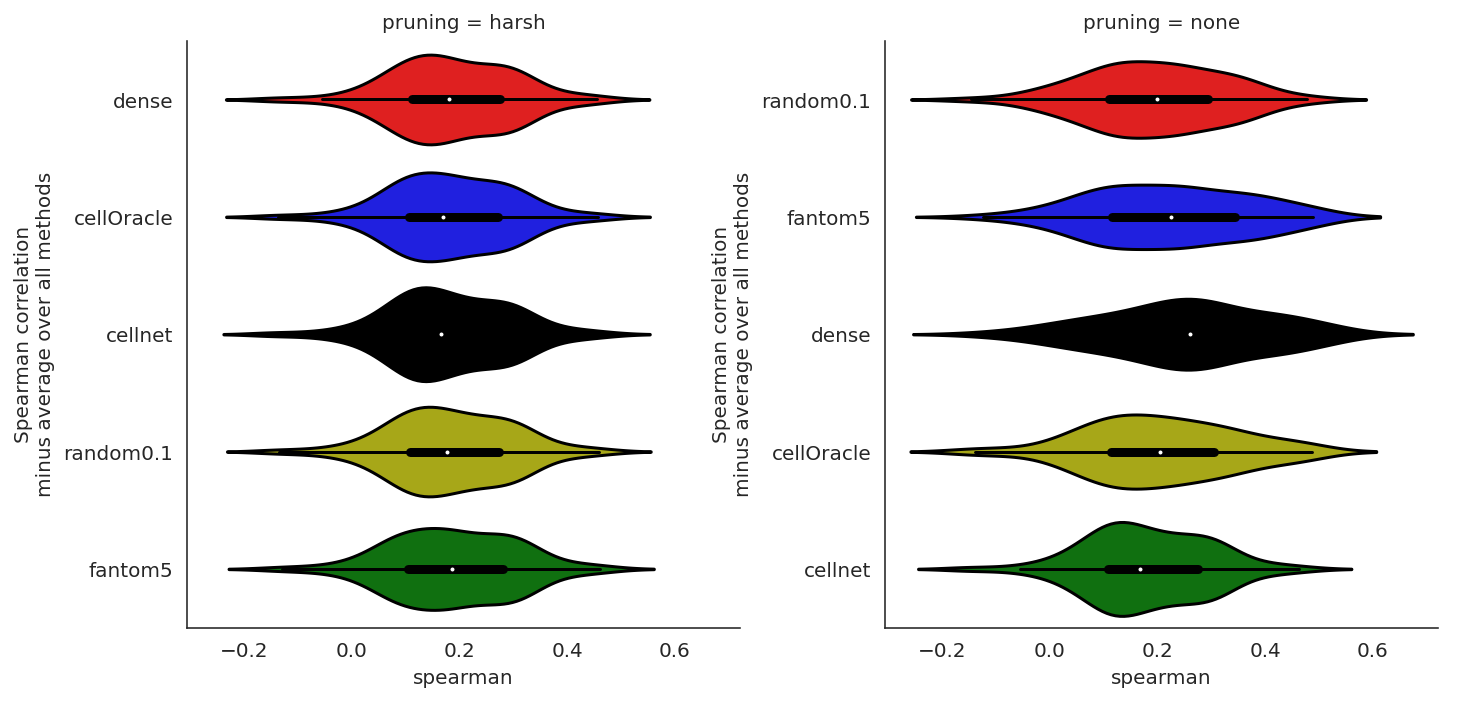

In [50]:
baseNetworkComparisonFigure = sns.FacetGrid(evaluationResults[~evaluationResults['somePredictionRefused']], 
                                            col = 'pruning',
                                            sharey = False, 
                                            height=5, 
                                            aspect=1).set(title = "Performance")
baseNetworkComparisonFigure.map(sns.violinplot, "spearman", "network", 
                                palette=["r", "b", "k", "y", "g"]
                               ).add_legend()
baseNetworkComparisonFigure.set(ylabel="Spearman correlation\nminus average over all methods")
plt.show()

  pruning     network  spearman     numEdges
0   harsh  cellOracle  0.183647    5134330.0
2   harsh     cellnet  0.181285     201422.0
4   harsh       dense  0.186683  102313295.0
6   harsh     fantom5  0.188518    3246008.0
8   harsh   random0.1  0.183992   10227517.0
1    none  cellOracle  0.204496    5134330.0
3    none     cellnet  0.180781     201422.0
5    none       dense  0.250846  102313295.0
7    none     fantom5  0.221177    3246008.0
9    none   random0.1  0.193617   10227517.0


<AxesSubplot:title={'center':'Density vs performance'}, xlabel='numEdges', ylabel='spearman'>

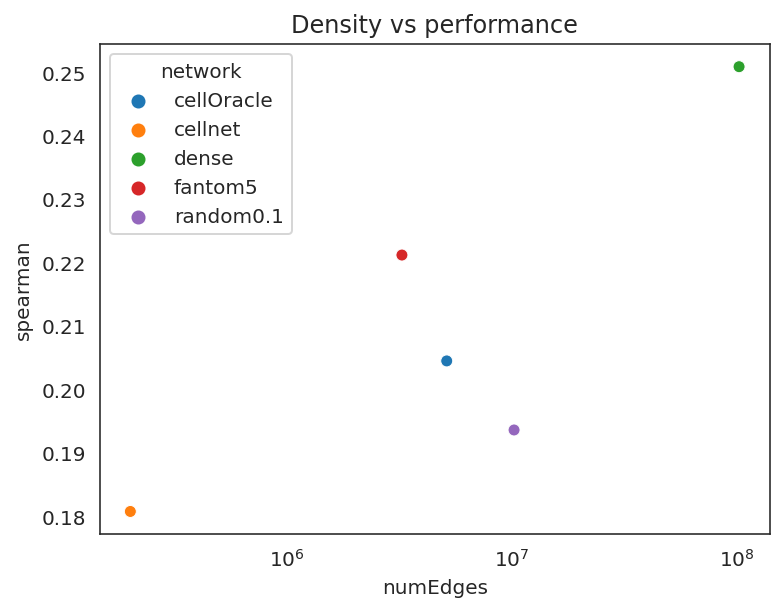

In [75]:
summary = evaluationResults[~evaluationResults['somePredictionRefused']]
summary = summary.groupby(["pruning", "network"]).mean()[["spearman"]].reset_index(["pruning", "network"])
summary = summary.merge(network_sizes)
summary.sort_values(['pruning', 'network'], inplace=True)
summary.to_csv("../results/" + VERSION + "/networksExperimentEvaluationSummary.csv")
print(summary)
baseNetworkComparisonFigureCompact = sns.scatterplot(data=summary[[p!="harsh" for p in summary["pruning"]]],
                x='numEdges',
                y='spearman', 
                hue='network')
baseNetworkComparisonFigureCompact.set_xscale("log")
baseNetworkComparisonFigureCompact.set(title="Density vs performance")
baseNetworkComparisonFigureCompact

### Save yourself

Copy the full notebook to a versioned set of results. 

In [76]:
!jupyter nbconvert in_silico_perturbation.ipynb --to=html

[NbConvertApp] Converting notebook in_silico_perturbation.ipynb to html
[NbConvertApp] Writing 4014904 bytes to in_silico_perturbation.html


In [80]:
os.rename("in_silico_perturbation.html", "../results/" + VERSION + "/in_silico_perturbation.html")
shutil.rename("in_silico_perturbation.ipynb", "../results/" + VERSION + "/in_silico_perturbation.ipynb")